In [0]:
!pip install nba-api
!pip install Keras

     |████████████████████████████████| 225kB 9.3MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [206]:
import pandas as pd
from pandas import ExcelFile
from pandas.plotting import scatter_matrix
import numpy as np
from datetime import datetime
import time
import requests
import json

import matplotlib.pyplot as plt

import nba_api
from nba_api.stats.static import teams
from nba_api.stats.endpoints import LeagueGameFinder, LeagueGameLog, PlayerGameLog
from nba_api.stats.endpoints import BoxScoreDefensive, BoxScoreMiscV2, BoxScorePlayerTrackV2, BoxScoreUsageV2

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, Normalizer, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

-------
# csv dataset
-------

In [0]:
csv_boxscores_adv = '2018-19_adv_boxscores.csv'
csv_gamelogs = '2018-19_gamelogs.csv'

In [0]:
df_boxscores_adv = pd.read_csv(csv_boxscores_adv)
df_gamelogs = pd.read_csv(csv_gamelogs)
df_boxscores_adv
# df_gamelogs

In [0]:
df_boxscores_adv.rename(columns= {'GAME_ID':'Game_ID', 'PLAYER_ID':'Player_ID', 'Unnamed: 0':'index_old'},inplace=True)
df_gamelogs.rename(columns={'Unnamed: 0':'index_old'}, inplace=True)

In [0]:
df_gamelogs.drop(columns='index_old', inplace=True)
df_boxscores_adv.drop(columns='index_old', inplace=True)

In [0]:
df_boxscores_adv.head()
df_gamelogs.head()

In [0]:
df = pd.merge(df_gamelogs, df_boxscores_adv, how='inner', on=['Game_ID','Player_ID'])
df.to_csv('test.csv')
df

In [0]:
list(df.keys())

In [0]:
# add advanced metrics 

df['Gamescore'] = (
    df['PTS'] +
    (0.4 * df['FGM']) - 
    (0.7 * df['FGA']) -
    (0.4 * (df['FTA'] - df['FTM']) ) +
    (0.7 * df['OREB']) +
    (0.3 * df['DREB']) +
    df['STL'] +
    (0.7 * df['AST']) +
    (0.7 * df['BLK']) -
    (0.4 * df['PF']) - 
    df['TOV']
)
    
# team possession

# team PER

df['FT_missed'] = (df['FTA'] - df['FTM'])


In [0]:
df.query('Player_ID == "203500"')['Game_ID'].agg(['nunique','count','size'])

In [0]:
gamedates = df['GAME_DATE']

for game in gamedates:
    gamesearch = df[df.Game_ID==game]
    len(gamesearch)

In [0]:
df.sort_values(by='Gamescore', ascending=False)

In [0]:
df.keys()

In [0]:
df_more_info = pd.read_csv('2018_games_more_info.csv')
df_more_info.rename(columns={'Unnamed: 0':'index_old'}, inplace=True)
df_more_info.drop(columns='index_old', inplace=True)
df_more_info.keys()

In [0]:
df_attendance = df_more_info.loc[:,['gameID','person_id','gameDate','attendance','arena']]
df_attendance.rename(columns={'gameID':'Game_ID', 'person_id':'Player_ID','gameDate':'GAME_DATE'}, inplace=True)
df_attendance

df_attendance.query('Player_ID == "203500"')['Game_ID'].agg(['nunique','count','size'])

In [0]:
print(type(df['GAME_DATE'][0]))

print(type(df_attendance['GAME_DATE'][0]))

In [0]:
df_attendance.GAME_DATE = df_attendance.GAME_DATE.astype('str', inplace=True)

In [0]:
df_attendance.query('Player_ID == "203500"')['Game_ID'].agg(['nunique','count','size'])

In [0]:
df_final = pd.merge(df, df_attendance, how='left', on=['Game_ID', 'Player_ID'])
df_final.to_csv('test-attendance-merge.csv')
df_final

In [0]:
df_final.query('Player_ID == "203500"')['Game_ID'].agg(['nunique','count','size'])

In [11]:
df_final.keys()

Index(['Column1', 'SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE_x',
       'MATCHUP', 'WL', 'MIN_x', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_NAME', 'START_POSITION',
       'COMMENT', 'MIN_y', 'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING',
       'DEF_RATING', 'E_NET_RATING', 'NET_RATING', 'AST_PCT', 'AST_TOV',
       'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT',
       'TS_PCT', 'USG_PCT', 'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40',
       'POSS', 'PIE', 'Gamescore', 'FT_missed', 'GAME_DATE_y', 'attendance',
       'arena', 'City', 'Hometeam', 'Capacity', 'Year Built', 'Home/Away',
       'Capacity_pct'],
      dtype='object')

In [0]:
# df_final = pd.read_csv('test-attendance-merge.csv')
# df_final = pd.read_csv('/content/drive/My Drive/nba_ml/current edition/test-attendance-merge.csv')

In [0]:
df_final

,Unnamed: 0,SEASON_ID,Player_ID,Game_ID,GAME_DATE_x,MATCHUP,WL,MIN_x,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_NAME,START_POSITION,COMMENT,MIN_y,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,Gamescore,FT_missed,GAME_DATE_y,attendance,arena
0,0,22018,203500,21801226,"APR 10, 2019",OKC @ MIL,W,12,1,5,0.200,0,0,0.0,2,4,0.500,2,0,2,0,0,1,0,1,4,-1,1,1610612760,OKC,Oklahoma City,Steven Adams,C,NaN,12:21,111.0,109.7,117.6,120.7,-6.6,-11.0,0.000,0.00,0.0,0.125,0.000,0.065,0.0,0.200,0.296,0.206,0.208,117.44,116.66,97.22,31,-0.022,1.8,2,20190410.0,18082.0,Fiserv Forum
1,1,22018,203500,21801218,"APR 09, 2019",OKC vs. HOU,W,37,3,11,0.273,0,0,0.0,2,4,0.500,8,5,13,1,0,0,0,1,8,2,1,1610612760,OKC,Oklahoma City,Steven Adams,C,NaN,36:33,111.8,116.2,112.6,115.1,-0.8,1.1,0.037,0.00,7.1,0.160,0.125,0.144,0.0,0.273,0.313,0.137,0.138,99.49,96.53,80.44,74,0.052,8.1,2,20190409.0,18203.0,Chesapeake Energy Arena
2,2,22018,203500,21801197,"APR 07, 2019",OKC @ MIN,W,27,4,5,0.800,0,0,0.0,0,0,0.000,2,4,6,1,1,0,3,6,8,31,1,1610612760,OKC,Oklahoma City,Steven Adams,C,NaN,27:28,140.7,145.0,90.9,93.3,49.8,51.7,0.034,0.33,11.1,0.100,0.148,0.128,33.3,0.800,0.800,0.119,0.118,107.87,104.86,87.38,60,0.040,5.0,0,20190407.0,18978.0,Target Center
3,3,22018,203500,21801186,"APR 05, 2019",OKC vs. DET,W,24,7,9,0.778,0,0,0.0,0,0,0.000,8,6,14,0,0,2,2,4,14,1,1,1610612760,OKC,Oklahoma City,Steven Adams,C,NaN,23:55,114.6,117.0,115.3,113.0,-0.6,4.0,0.000,0.00,0.0,0.286,0.240,0.264,18.2,0.778,0.778,0.169,0.169,107.37,107.37,89.48,53,0.151,15.7,0,20190405.0,18203.0,Chesapeake Energy Arena
4,4,22018,203500,21801161,"APR 02, 2019",OKC vs. LAL,W,33,6,11,0.545,0,0,0.0,1,7,0.143,7,1,8,3,1,5,2,2,13,26,1,1610612760,OKC,Oklahoma City,Steven Adams,C,NaN,33:10,125.4,129.6,86.5,94.3,38.9,35.3,0.103,1.50,15.8,0.159,0.029,0.103,10.5,0.545,0.462,0.180,0.181,108.29,102.01,85.01,71,0.062,14.3,6,20190402.0,18203.0,Chesapeake Energy Arena
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22618,22618,22018,1627826,21800183,"NOV 10, 2018",LAL @ SAC,W,2,0,2,0.000,0,0,0.0,0,0,0.000,1,1,2,0,0,0,0,0,0,-1,1,1610612747,LAL,Los Angeles,Ivica Zubac,NaN,NaN,1:39,104.2,75.0,103.1,100.0,1.1,-25.0,0.000,0.00,0.0,0.333,0.333,0.333,0.0,0.000,0.000,0.400,0.515,98.33,116.36,96.97,4,-0.125,-0.4,0,20181110.0,17583.0,Golden 1 Center
22619,22619,22018,1627826,21800139,"NOV 04, 2018",LAL vs. TOR,L,11,1,3,0.333,0,0,0.0,3,3,1.000,2,4,6,1,0,0,1,4,5,1,1,1610612747,LAL,Los Angeles,Ivica Zubac,NaN,NaN,11:12,75.4,76.0,71.4,72.0,4.0,4.0,0.167,1.00,16.7,0.143,0.286,0.214,16.7,0.333,0.579,0.179,0.184,108.00,107.14,89.29,25,0.186,4.0,0,20181104.0,18997.0,Staples Center
22620,22620,22018,1627826,21800132,"NOV 03, 2018",LAL @ POR,W,20,4,5,0.800,0,0,0.0,1,1,1.000,4,4,8,0,1,0,2,3,9,15,1,1610612747,LAL,Los Angeles,Ivica Zubac,NaN,NaN,19:39,114.4,106.5,72.2,73.9,42.2,32.6,0.000,0.00,0.0,0.250,0.154,0.190,28.6,0.800,0.827,0.137,0.146,109.81,112.35,93.62,46,0.169,8.9,0,20181103.0,19848.0,Moda Center
22621,22621,22018,1627826,21800060,"OCT 24, 2018",LAL @ PHX,W,2,0,1,0.000,0,0,0.0,0,0,0.000,1,1,2,1,0,0,0,0,0,-4,1,1610612747,LAL,Los Angeles,Ivica Zubac,NaN,NaN,2:20,66.7,57.1,136.1,133.3,-69.4,-76.2,0.500,0.00,50.0,0.333,1.000,0.500,0.0,0.000,0.000,0.125,0.143,122.19,133.71,111.43,7,0.115,1.0,0,20181024.0,18055.0,Talking Stick Resort Arena


In [76]:
df_final = pd.read_csv('nba_gamedata_201819.csv')

# df_final = pd.read_csv('/content/drive/My Drive/nba_ml/current edition/nba_gamedata_201819.csv')

In [0]:
df_final.sort_values('attendance')

,Column1,SEASON_ID,Player_ID,Game_ID,GAME_DATE_x,MATCHUP,WL,MIN_x,FGM,FGA,...,Gamescore,FT_missed,GAME_DATE_y,attendance,arena,City,Hometeam,Capacity,Year Built,Home/Away
17775,17801,22018,203939,21800844,11-Feb-19,DAL @ HOU,L,28,4,5,...,9.1,2,20190211,0,Toyota Center,Houston Texas,HOU,18055,2003,AWAY
8221,8236,22018,201569,21800844,11-Feb-19,HOU vs. DAL,W,29,7,17,...,10.5,0,20190211,0,Toyota Center,Houston Texas,HOU,18055,2003,HOME
13264,13286,22018,201584,21800844,11-Feb-19,DAL @ HOU,L,6,0,0,...,0.0,0,20190211,0,Toyota Center,Houston Texas,HOU,18055,2003,AWAY
19659,19689,22018,203935,21801203,7-Apr-19,BOS vs. ORL,L,20,2,5,...,7.9,0,20190407,0,TD Garden,Boston Massachusetts,BOS,18624,1995,HOME
10396,10413,22018,201143,21801203,7-Apr-19,BOS vs. ORL,L,26,7,12,...,17.3,1,20190407,0,TD Garden,Boston Massachusetts,BOS,18624,1995,HOME
18253,18281,22018,203085,21800844,11-Feb-19,HOU vs. DAL,W,17,3,4,...,4.8,1,20190211,0,Toyota Center,Houston Texas,HOU,18055,2003,HOME
7164,7175,22018,203095,21801203,7-Apr-19,ORL @ BOS,W,36,8,16,...,18.2,0,20190407,0,TD Garden,Boston Massachusetts,BOS,18624,1995,AWAY
3131,3139,22018,1627759,21801203,7-Apr-19,BOS vs. ORL,L,26,5,8,...,9.8,1,20190407,0,TD Garden,Boston Massachusetts,BOS,18624,1995,HOME
9538,9555,22018,202330,21801203,7-Apr-19,BOS vs. ORL,L,38,8,14,...,13.3,0,20190407,0,TD Garden,Boston Massachusetts,BOS,18624,1995,HOME
9501,9518,22018,1628392,21800844,11-Feb-19,HOU vs. DAL,W,13,1,1,...,4.2,0,20190211,0,Toyota Center,Houston Texas,HOU,18055,2003,HOME


In [0]:
df_final['arena'].unique()

array(['Fiserv Forum', 'Chesapeake Energy Arena', 'Target Center',
       'FedEx Forum', 'Scotiabank Arena', 'Bankers Life Fieldhouse',
       'Vivint Smart Home Arena', 'Staples Center', 'Moda Center',
       'AT&T Center', 'Pepsi Center', 'Smoothie King Center',
       'Toyota Center', 'TD Garden', 'American Airlines Arena',
       'Madison Square Garden', 'Wells Fargo Center', 'State Farm Arena',
       'American Airlines Center', 'Talking Stick Resort Arena',
       'Golden 1 Center', 'United Center', 'Barclays Center',
       'Little Caesars Arena', 'ORACLE Arena', 'Quicken Loans Arena',
       'Capital One Arena', 'Spectrum Center', 'Amway Center',
       'Arena Ciudad de Mexico', 'The O2 Arena',
       'Rocket Mortgage FieldHouse'], dtype=object)

In [78]:
df_final['Capacity_pct'] = df_final['attendance']/df_final['Capacity']
df_final.head()

,Column1,SEASON_ID,Player_ID,Game_ID,GAME_DATE_x,MATCHUP,WL,MIN_x,FGM,FGA,...,FT_missed,GAME_DATE_y,attendance,arena,City,Hometeam,Capacity,Year Built,Home/Away,Capacity_pct
0,0,22018,203500,21801226,10-Apr-19,OKC @ MIL,W,12,1,5,...,2,20190410,18082,Fiserv Forum,Milwaukee Wisconsin,MIL,17500,2018,AWAY,1.033257
1,1,22018,203500,21801218,9-Apr-19,OKC vs. HOU,W,37,3,11,...,2,20190409,18203,Chesapeake Energy Arena,Oklahoma City Oklahoma,OKC,18203,2002,HOME,1.000000
2,2,22018,203500,21801197,7-Apr-19,OKC @ MIN,W,27,4,5,...,0,20190407,18978,Target Center,Minneapolis Minnesota,MIN,18978,1990,AWAY,1.000000
3,3,22018,203500,21801186,5-Apr-19,OKC vs. DET,W,24,7,9,...,0,20190405,18203,Chesapeake Energy Arena,Oklahoma City Oklahoma,OKC,18203,2002,HOME,1.000000
4,4,22018,203500,21801161,2-Apr-19,OKC vs. LAL,W,33,6,11,...,6,20190402,18203,Chesapeake Energy Arena,Oklahoma City Oklahoma,OKC,18203,2002,HOME,1.000000


In [79]:
# fix gameid column w/ leading zeros
df_final['Game_ID'] = df_final['Game_ID'].map(lambda x: f'{x:0>10}')

In [81]:
df_final

,Column1,SEASON_ID,PLAYER_ID,GAME_ID,GAME_DATE_x,MATCHUP,WL,MIN_x,FGM,FGA,...,FT_missed,GAME_DATE_y,attendance,arena,City,Hometeam,Capacity,Year Built,Home/Away,Capacity_pct
0,0,22018,203500,0021801226,10-Apr-19,OKC @ MIL,W,12,1,5,...,2,20190410,18082,Fiserv Forum,Milwaukee Wisconsin,MIL,17500,2018,AWAY,1.033257
1,1,22018,203500,0021801218,9-Apr-19,OKC vs. HOU,W,37,3,11,...,2,20190409,18203,Chesapeake Energy Arena,Oklahoma City Oklahoma,OKC,18203,2002,HOME,1.000000
2,2,22018,203500,0021801197,7-Apr-19,OKC @ MIN,W,27,4,5,...,0,20190407,18978,Target Center,Minneapolis Minnesota,MIN,18978,1990,AWAY,1.000000
3,3,22018,203500,0021801186,5-Apr-19,OKC vs. DET,W,24,7,9,...,0,20190405,18203,Chesapeake Energy Arena,Oklahoma City Oklahoma,OKC,18203,2002,HOME,1.000000
4,4,22018,203500,0021801161,2-Apr-19,OKC vs. LAL,W,33,6,11,...,6,20190402,18203,Chesapeake Energy Arena,Oklahoma City Oklahoma,OKC,18203,2002,HOME,1.000000
5,5,22018,203500,0021801146,31-Mar-19,OKC vs. DAL,L,39,10,17,...,3,20190331,18203,Chesapeake Energy Arena,Oklahoma City Oklahoma,OKC,18203,2002,HOME,1.000000
6,6,22018,203500,0021801133,29-Mar-19,OKC vs. DEN,L,35,8,12,...,1,20190329,18203,Chesapeake Energy Arena,Oklahoma City Oklahoma,OKC,18203,2002,HOME,1.000000
7,7,22018,203500,0021801119,27-Mar-19,OKC vs. IND,W,35,11,14,...,3,20190327,18203,Chesapeake Energy Arena,Oklahoma City Oklahoma,OKC,18203,2002,HOME,1.000000
8,8,22018,203500,0021801104,25-Mar-19,OKC @ MEM,L,32,1,7,...,0,20190325,15144,FedEx Forum,Memphis Tennessee,MEM,17794,2004,AWAY,0.851073
9,9,22018,203500,0021801083,22-Mar-19,OKC @ TOR,W,33,4,9,...,1,20190322,20014,Scotiabank Arena,Toronto Ontario,TOR,19800,1999,AWAY,1.010808


# add more stats

### player tracking

In [80]:
df_final = df_final.rename(columns={'Player_ID':'PLAYER_ID', 'Game_ID':'GAME_ID'})
df_final.head()

,Column1,SEASON_ID,PLAYER_ID,GAME_ID,GAME_DATE_x,MATCHUP,WL,MIN_x,FGM,FGA,...,FT_missed,GAME_DATE_y,attendance,arena,City,Hometeam,Capacity,Year Built,Home/Away,Capacity_pct
0,0,22018,203500,0021801226,10-Apr-19,OKC @ MIL,W,12,1,5,...,2,20190410,18082,Fiserv Forum,Milwaukee Wisconsin,MIL,17500,2018,AWAY,1.033257
1,1,22018,203500,0021801218,9-Apr-19,OKC vs. HOU,W,37,3,11,...,2,20190409,18203,Chesapeake Energy Arena,Oklahoma City Oklahoma,OKC,18203,2002,HOME,1.000000
2,2,22018,203500,0021801197,7-Apr-19,OKC @ MIN,W,27,4,5,...,0,20190407,18978,Target Center,Minneapolis Minnesota,MIN,18978,1990,AWAY,1.000000
3,3,22018,203500,0021801186,5-Apr-19,OKC vs. DET,W,24,7,9,...,0,20190405,18203,Chesapeake Energy Arena,Oklahoma City Oklahoma,OKC,18203,2002,HOME,1.000000
4,4,22018,203500,0021801161,2-Apr-19,OKC vs. LAL,W,33,6,11,...,6,20190402,18203,Chesapeake Energy Arena,Oklahoma City Oklahoma,OKC,18203,2002,HOME,1.000000


In [218]:
test_array = df_final['GAME_ID'].unique()[:10]
unique_array = df_final['GAME_ID'].unique()
test_df = df_final.copy()

In [220]:
df_def_list = []
df_misc_list = []
df_tracking_list = []
df_usage_list = []

startTime = datetime.now()

game_ok_count = 0
game_no_count = 0

game_problem_list = []

for game in unique_array:
  
    try:

        print(f'Searching for game: {game}...')

        df_defensive = BoxScoreDefensive(game_id=game).get_data_frames()[0]
        time.sleep(1)
        print(f' 1.Defensive df found and saved')

        df_misc = BoxScoreMiscV2(game_id=game).get_data_frames()[0]
        time.sleep(1)
        print(f' 2.Misc df found and saved')

        df_tracking = BoxScorePlayerTrackV2(game_id=game).get_data_frames()[0]
        time.sleep(1)
        print(f' 3.Tracking df found and saved')

        df_usage = BoxScoreUsageV2(game_id=game).get_data_frames()[0]
        time.sleep(1)
        print(f' 4.Usage df found and saved')

        x, = np.where(unique_array == game)

        game_ok_count += 1

        print(f'--- {x+1} games searched ---')
        print(f'--- {game_ok_count} games found ---')

        time.sleep(5)

        df_def_list.append(df_defensive)
        df_misc_list.append(df_misc)
        df_tracking_list.append(df_tracking)
        df_usage_list.append(df_usage)

        print(f'--- {game_ok_count} games appended ---')

        print(f'--- Time: {datetime.now() - startTime} ---')

    except:
    
    #   problem list
        game_no_count += 1

        game_problem_list.append(game)

        print(f'game {game} encountered timeout')
        print(f'--- {game_no_count} games with problems ---')

    #   sleep
        print(f'--- sleeping for 300 seconds ---')
        time.sleep(300)


    #   try again to search

        try:

            print(f'Searching again for game: {game}...')

            df_defensive = BoxScoreDefensive(game_id=game).get_data_frames()[0]
            time.sleep(1)
            print(f' 1.Defensive df found and saved')

            df_misc = BoxScoreMiscV2(game_id=game).get_data_frames()[0]
            time.sleep(1)
            print(f' 2.Misc df found and saved')

            df_tracking = BoxScorePlayerTrackV2(game_id=game).get_data_frames()[0]
            time.sleep(1)
            print(f' 3.Tracking df found and saved')

            df_usage = BoxScoreUsageV2(game_id=game).get_data_frames()[0]
            time.sleep(1)
            print(f' 4.Usage df found and saved')

            x, = np.where(unique_array == game)

            game_ok_count += 1

            print(f'--- {x+1} games searched ---')
            print(f'--- {game_ok_count} games found ---')

            time.sleep(5)

            df_def_list.append(df_defensive)
            df_misc_list.append(df_misc)
            df_tracking_list.append(df_tracking)
            df_usage_list.append(df_usage)

            print(f'--- {game_ok_count} games appended ---')

            print(f'--- Time: {datetime.now() - startTime} ---')

        except:

            print(f'game {game} encountered another timeout')
            print(f'--- {game_no_count} games with problems ---')

        #   sleep
            print(f'--- sleeping for 300 seconds ---')
            time.sleep(300)

            continue

    continue

    
df_def_all = pd.concat(df_def_list)
df_misc_all = pd.concat(df_misc_list)
df_tracking_all = pd.concat(df_tracking_list)
df_usage_all = pd.concat(df_usage_list)


print(f'--- merged df ---')

Searching for game: 0021801226...
game 0021801226 encountered timeout
--- 1 games with problems ---
--- sleeping for 300 seconds ---
Searching again for game: 0021801226...
game 0021801226 encountered another timeout
--- 1 games with problems ---
--- sleeping for 300 seconds ---
Searching for game: 0021801218...
game 0021801218 encountered timeout
--- 2 games with problems ---
--- sleeping for 300 seconds ---
Searching again for game: 0021801218...
game 0021801218 encountered another timeout
--- 2 games with problems ---
--- sleeping for 300 seconds ---
Searching for game: 0021801197...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [3] games searched ---
--- 1 games found ---
--- 1 games appended ---
--- Time: 0:21:17.863752 ---
Searching for game: 0021801186...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [4] games searched ---
--- 2 

--- 30 games appended ---
--- Time: 0:30:55.767091 ---
Searching for game: 0021800738...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [33] games searched ---
--- 31 games found ---
--- 31 games appended ---
--- Time: 0:31:16.443928 ---
Searching for game: 0021800717...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [34] games searched ---
--- 32 games found ---
--- 32 games appended ---
--- Time: 0:31:35.702717 ---
Searching for game: 0021800703...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [35] games searched ---
--- 33 games found ---
--- 33 games appended ---
--- Time: 0:31:52.393415 ---
Searching for game: 0021800691...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [36] games sear

--- 62 games appended ---
--- Time: 0:41:48.261260 ---
Searching for game: 0021800264...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [65] games searched ---
--- 63 games found ---
--- 63 games appended ---
--- Time: 0:42:09.870319 ---
Searching for game: 0021800247...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [66] games searched ---
--- 64 games found ---
--- 64 games appended ---
--- Time: 0:42:31.269089 ---
Searching for game: 0021800233...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [67] games searched ---
--- 65 games found ---
--- 65 games appended ---
--- Time: 0:42:52.681578 ---
Searching for game: 0021800209...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [68] games sear

--- 94 games appended ---
--- Time: 0:52:36.672250 ---
Searching for game: 0021800979...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [97] games searched ---
--- 95 games found ---
--- 95 games appended ---
--- Time: 0:52:58.553692 ---
Searching for game: 0021800965...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [98] games searched ---
--- 96 games found ---
--- 96 games appended ---
--- Time: 0:53:19.168537 ---
Searching for game: 0021800953...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [99] games searched ---
--- 97 games found ---
--- 97 games appended ---
--- Time: 0:53:37.292177 ---
Searching for game: 0021800937...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [100] games sea

 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [128] games searched ---
--- 126 games found ---
--- 126 games appended ---
--- Time: 1:03:10.954557 ---
Searching for game: 0021800491...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [129] games searched ---
--- 127 games found ---
--- 127 games appended ---
--- Time: 1:03:28.766761 ---
Searching for game: 0021800482...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [130] games searched ---
--- 128 games found ---
--- 128 games appended ---
--- Time: 1:03:46.480697 ---
Searching for game: 0021800467...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [131] games searched ---
--- 129 games found ---
--- 129 games appended ---
--- Time: 1:04:05.121746 ---
Searching for game: 00

--- 157 games appended ---
--- Time: 1:13:36.631963 ---
Searching for game: 0021801227...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [160] games searched ---
--- 158 games found ---
--- 158 games appended ---
--- Time: 1:13:59.157586 ---
Searching for game: 0021801196...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [161] games searched ---
--- 159 games found ---
--- 159 games appended ---
--- Time: 1:14:19.132146 ---
Searching for game: 0021801182...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [162] games searched ---
--- 160 games found ---
--- 160 games appended ---
--- Time: 1:14:38.176430 ---
Searching for game: 0021801173...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [163]

 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [191] games searched ---
--- 189 games found ---
--- 189 games appended ---
--- Time: 1:24:21.458205 ---
Searching for game: 0021800674...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [192] games searched ---
--- 190 games found ---
--- 190 games appended ---
--- Time: 1:24:42.454557 ---
Searching for game: 0021800661...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [193] games searched ---
--- 191 games found ---
--- 191 games appended ---
--- Time: 1:25:05.284983 ---
Searching for game: 0021800647...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [194] games searched ---
--- 192 games found ---
--- 192 games appended ---
--- Time: 1:25:27.404772 ---
Searching for game: 00

--- 220 games appended ---
--- Time: 1:34:47.139563 ---
Searching for game: 0021800215...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [223] games searched ---
--- 221 games found ---
--- 221 games appended ---
--- Time: 1:35:03.822415 ---
Searching for game: 0021800211...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [224] games searched ---
--- 222 games found ---
--- 222 games appended ---
--- Time: 1:35:22.568135 ---
Searching for game: 0021800197...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [225] games searched ---
--- 223 games found ---
--- 223 games appended ---
--- Time: 1:35:44.074199 ---
Searching for game: 0021800180...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [226]

 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [254] games searched ---
--- 252 games found ---
--- 252 games appended ---
--- Time: 1:45:17.226440 ---
Searching for game: 0021800367...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [255] games searched ---
--- 253 games found ---
--- 253 games appended ---
--- Time: 1:45:35.856641 ---
Searching for game: 0021800299...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [256] games searched ---
--- 254 games found ---
--- 254 games appended ---
--- Time: 1:45:54.804524 ---
Searching for game: 0021800292...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [257] games searched ---
--- 255 games found ---
--- 255 games appended ---
--- Time: 1:46:15.589033 ---
Searching for game: 00

--- 283 games appended ---
--- Time: 1:55:43.521961 ---
Searching for game: 0021800914...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [286] games searched ---
--- 284 games found ---
--- 284 games appended ---
--- Time: 1:56:03.382370 ---
Searching for game: 0021800884...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [287] games searched ---
--- 285 games found ---
--- 285 games appended ---
--- Time: 1:56:23.145538 ---
Searching for game: 0021800869...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [288] games searched ---
--- 286 games found ---
--- 286 games appended ---
--- Time: 1:56:41.887388 ---
Searching for game: 0021800853...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [289]

 3.Tracking df found and saved
 4.Usage df found and saved
--- [316] games searched ---
--- 314 games found ---
--- 314 games appended ---
--- Time: 2:12:51.014098 ---
Searching for game: 0021800422...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [317] games searched ---
--- 315 games found ---
--- 315 games appended ---
--- Time: 2:13:10.023252 ---
Searching for game: 0021800408...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [318] games searched ---
--- 316 games found ---
--- 316 games appended ---
--- Time: 2:13:30.029803 ---
Searching for game: 0021800382...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [319] games searched ---
--- 317 games found ---
--- 317 games appended ---
--- Time: 2:13:51.848406 ---
Searching for game: 0021800371...
 1.Defensive df

--- 345 games appended ---
--- Time: 2:23:05.325082 ---
Searching for game: 0021801053...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [348] games searched ---
--- 346 games found ---
--- 346 games appended ---
--- Time: 2:23:24.476323 ---
Searching for game: 0021801042...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [349] games searched ---
--- 347 games found ---
--- 347 games appended ---
--- Time: 2:23:43.319148 ---
Searching for game: 0021800865...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [350] games searched ---
--- 348 games found ---
--- 348 games appended ---
--- Time: 2:24:03.287162 ---
Searching for game: 0021800856...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [351]

 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [379] games searched ---
--- 377 games found ---
--- 377 games appended ---
--- Time: 2:34:07.455932 ---
Searching for game: 0021800862...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [380] games searched ---
--- 378 games found ---
--- 378 games appended ---
--- Time: 2:34:25.382002 ---
Searching for game: 0021800834...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [381] games searched ---
--- 379 games found ---
--- 379 games appended ---
--- Time: 2:34:47.404609 ---
Searching for game: 0021800734...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [382] games searched ---
--- 380 games found ---
--- 380 games appended ---
--- Time: 2:35:08.284117 ---
Searching for game: 00

--- 408 games appended ---
--- Time: 2:44:37.037912 ---
Searching for game: 0021800277...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [411] games searched ---
--- 409 games found ---
--- 409 games appended ---
--- Time: 2:44:56.287875 ---
Searching for game: 0021800259...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [412] games searched ---
--- 410 games found ---
--- 410 games appended ---
--- Time: 2:45:15.745432 ---
Searching for game: 0021800251...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [413] games searched ---
--- 411 games found ---
--- 411 games appended ---
--- Time: 2:45:37.557879 ---
Searching for game: 0021800237...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [414]

 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [442] games searched ---
--- 440 games found ---
--- 440 games appended ---
--- Time: 2:55:37.931382 ---
Searching for game: 0021800303...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [443] games searched ---
--- 441 games found ---
--- 441 games appended ---
--- Time: 2:56:02.553261 ---
Searching for game: 0021800291...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [444] games searched ---
--- 442 games found ---
--- 442 games appended ---
--- Time: 2:56:29.146798 ---
Searching for game: 0021800266...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [445] games searched ---
--- 443 games found ---
--- 443 games appended ---
--- Time: 2:56:55.761948 ---
Searching for game: 00

--- 471 games appended ---
--- Time: 3:06:56.446443 ---
Searching for game: 0021801096...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [474] games searched ---
--- 472 games found ---
--- 472 games appended ---
--- Time: 3:07:14.253538 ---
Searching for game: 0021801043...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [475] games searched ---
--- 473 games found ---
--- 473 games appended ---
--- Time: 3:07:34.228503 ---
Searching for game: 0021801010...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [476] games searched ---
--- 474 games found ---
--- 474 games appended ---
--- Time: 3:07:51.851308 ---
Searching for game: 0021800990...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [477]

 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [505] games searched ---
--- 503 games found ---
--- 503 games appended ---
--- Time: 3:17:31.025617 ---
Searching for game: 0021800443...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [506] games searched ---
--- 504 games found ---
--- 504 games appended ---
--- Time: 3:17:52.840677 ---
Searching for game: 0021800423...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [507] games searched ---
--- 505 games found ---
--- 505 games appended ---
--- Time: 3:18:13.524435 ---
Searching for game: 0021800407...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [508] games searched ---
--- 506 games found ---
--- 506 games appended ---
--- Time: 3:18:33.186509 ---
Searching for game: 00

--- 534 games appended ---
--- Time: 3:28:13.801112 ---
Searching for game: 0021800983...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [537] games searched ---
--- 535 games found ---
--- 535 games appended ---
--- Time: 3:28:34.497177 ---
Searching for game: 0021800961...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [538] games searched ---
--- 536 games found ---
--- 536 games appended ---
--- Time: 3:28:53.436420 ---
Searching for game: 0021800949...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [539] games searched ---
--- 537 games found ---
--- 537 games appended ---
--- Time: 3:29:14.114529 ---
Searching for game: 0021800909...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [540]

 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [568] games searched ---
--- 566 games found ---
--- 566 games appended ---
--- Time: 3:38:46.240899 ---
Searching for game: 0021800161...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [569] games searched ---
--- 567 games found ---
--- 567 games appended ---
--- Time: 3:39:04.937929 ---
Searching for game: 0021800139...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [570] games searched ---
--- 568 games found ---
--- 568 games appended ---
--- Time: 3:39:26.898720 ---
Searching for game: 0021800055...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [571] games searched ---
--- 569 games found ---
--- 569 games appended ---
--- Time: 3:39:49.110720 ---
Searching for game: 00

--- 597 games appended ---
--- Time: 3:49:25.076024 ---
Searching for game: 0021800776...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [600] games searched ---
--- 598 games found ---
--- 598 games appended ---
--- Time: 3:49:47.922274 ---
Searching for game: 0021800735...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [601] games searched ---
--- 599 games found ---
--- 599 games appended ---
--- Time: 3:50:05.785439 ---
Searching for game: 0021800723...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [602] games searched ---
--- 600 games found ---
--- 600 games appended ---
--- Time: 3:50:24.628364 ---
Searching for game: 0021800712...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [603]

 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [631] games searched ---
--- 629 games found ---
--- 629 games appended ---
--- Time: 3:59:58.999435 ---
Searching for game: 0021800076...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [632] games searched ---
--- 630 games found ---
--- 630 games appended ---
--- Time: 4:00:20.717404 ---
Searching for game: 0021800067...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [633] games searched ---
--- 631 games found ---
--- 631 games appended ---
--- Time: 4:00:41.504870 ---
Searching for game: 0021800056...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [634] games searched ---
--- 632 games found ---
--- 632 games appended ---
--- Time: 4:01:01.466372 ---
Searching for game: 00

--- 660 games appended ---
--- Time: 4:10:14.538598 ---
Searching for game: 0021800530...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [663] games searched ---
--- 661 games found ---
--- 661 games appended ---
--- Time: 4:10:33.381144 ---
Searching for game: 0021800502...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [664] games searched ---
--- 662 games found ---
--- 662 games appended ---
--- Time: 4:10:54.946920 ---
Searching for game: 0021800487...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [665] games searched ---
--- 663 games found ---
--- 663 games appended ---
--- Time: 4:11:14.755238 ---
Searching for game: 0021800480...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [666]

 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [694] games searched ---
--- 692 games found ---
--- 692 games appended ---
--- Time: 4:20:45.854395 ---
Searching for game: 0021800864...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [695] games searched ---
--- 693 games found ---
--- 693 games appended ---
--- Time: 4:21:05.620593 ---
Searching for game: 0021800851...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [696] games searched ---
--- 694 games found ---
--- 694 games appended ---
--- Time: 4:21:21.391527 ---
Searching for game: 0021800837...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [697] games searched ---
--- 695 games found ---
--- 695 games appended ---
--- Time: 4:21:43.306348 ---
Searching for game: 00

--- 723 games appended ---
--- Time: 4:30:56.472528 ---
Searching for game: 0021800154...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [726] games searched ---
--- 724 games found ---
--- 724 games appended ---
--- Time: 4:31:18.725959 ---
Searching for game: 0021800142...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [727] games searched ---
--- 725 games found ---
--- 725 games appended ---
--- Time: 4:31:37.638277 ---
Searching for game: 0021800117...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [728] games searched ---
--- 726 games found ---
--- 726 games appended ---
--- Time: 4:31:57.710475 ---
Searching for game: 0021800098...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [729]

 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [757] games searched ---
--- 755 games found ---
--- 755 games appended ---
--- Time: 4:41:32.657415 ---
Searching for game: 0021800590...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [758] games searched ---
--- 756 games found ---
--- 756 games appended ---
--- Time: 4:41:53.088156 ---
Searching for game: 0021800573...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [759] games searched ---
--- 757 games found ---
--- 757 games appended ---
--- Time: 4:42:14.791830 ---
Searching for game: 0021800561...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [760] games searched ---
--- 758 games found ---
--- 758 games appended ---
--- Time: 4:42:37.516893 ---
Searching for game: 00

--- 786 games appended ---
--- Time: 4:51:56.739264 ---
Searching for game: 0021800225...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [789] games searched ---
--- 787 games found ---
--- 787 games appended ---
--- Time: 4:52:18.550038 ---
Searching for game: 0021800199...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [790] games searched ---
--- 788 games found ---
--- 788 games appended ---
--- Time: 4:52:38.425058 ---
Searching for game: 0021800184...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [791] games searched ---
--- 789 games found ---
--- 789 games appended ---
--- Time: 4:52:57.580464 ---
Searching for game: 0021800168...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [792]

--- 817 games appended ---
--- Time: 5:08:10.184538 ---
Searching for game: 0021800372...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [820] games searched ---
--- 818 games found ---
--- 818 games appended ---
--- Time: 5:08:31.993075 ---
Searching for game: 0021800318...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [821] games searched ---
--- 819 games found ---
--- 819 games appended ---
--- Time: 5:08:52.572690 ---
Searching for game: 0021800285...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [822] games searched ---
--- 820 games found ---
--- 820 games appended ---
--- Time: 5:09:11.005768 ---
Searching for game: 0021800263...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [823]

 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [851] games searched ---
--- 849 games found ---
--- 849 games appended ---
--- Time: 5:18:48.757105 ---
Searching for game: 0021800109...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [852] games searched ---
--- 850 games found ---
--- 850 games appended ---
--- Time: 5:19:05.453429 ---
Searching for game: 0021800093...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [853] games searched ---
--- 851 games found ---
--- 851 games appended ---
--- Time: 5:19:27.157802 ---
Searching for game: 0021800066...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [854] games searched ---
--- 852 games found ---
--- 852 games appended ---
--- Time: 5:19:46.202522 ---
Searching for game: 00

--- 880 games appended ---
--- Time: 5:28:54.675779 ---
Searching for game: 0021800780...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [883] games searched ---
--- 881 games found ---
--- 881 games appended ---
--- Time: 5:29:15.669094 ---
Searching for game: 0021800764...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [884] games searched ---
--- 882 games found ---
--- 882 games appended ---
--- Time: 5:29:34.303589 ---
Searching for game: 0021800726...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [885] games searched ---
--- 883 games found ---
--- 883 games appended ---
--- Time: 5:29:55.498718 ---
Searching for game: 0021800704...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [886]

 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [914] games searched ---
--- 912 games found ---
--- 912 games appended ---
--- Time: 5:39:45.332327 ---
Searching for game: 0021800655...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [915] games searched ---
--- 913 games found ---
--- 913 games appended ---
--- Time: 5:40:06.022267 ---
Searching for game: 0021800012...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [916] games searched ---
--- 914 games found ---
--- 914 games appended ---
--- Time: 5:40:24.962812 ---
Searching for game: 0021801172...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [917] games searched ---
--- 915 games found ---
--- 915 games appended ---
--- Time: 5:40:44.854314 ---
Searching for game: 00

--- 943 games appended ---
--- Time: 5:50:30.674948 ---
Searching for game: 0021800368...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [946] games searched ---
--- 944 games found ---
--- 944 games appended ---
--- Time: 5:50:52.178348 ---
Searching for game: 0021800320...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [947] games searched ---
--- 945 games found ---
--- 945 games appended ---
--- Time: 5:51:14.707167 ---
Searching for game: 0021800149...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [948] games searched ---
--- 946 games found ---
--- 946 games appended ---
--- Time: 5:51:36.211725 ---
Searching for game: 0021800078...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [949]

 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [977] games searched ---
--- 975 games found ---
--- 975 games appended ---
--- Time: 6:02:05.478596 ---
Searching for game: 0021800001...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [978] games searched ---
--- 976 games found ---
--- 976 games appended ---
--- Time: 6:02:23.391165 ---
Searching for game: 0021801220...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [979] games searched ---
--- 977 games found ---
--- 977 games appended ---
--- Time: 6:02:43.261520 ---
Searching for game: 0021801168...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [980] games searched ---
--- 978 games found ---
--- 978 games appended ---
--- Time: 6:03:05.383063 ---
Searching for game: 00

--- 1006 games appended ---
--- Time: 6:12:12.818897 ---
Searching for game: 0021800007...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1009] games searched ---
--- 1007 games found ---
--- 1007 games appended ---
--- Time: 6:12:32.786794 ---
Searching for game: 0021801211...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1010] games searched ---
--- 1008 games found ---
--- 1008 games appended ---
--- Time: 6:12:52.553240 ---
Searching for game: 0021801204...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1011] games searched ---
--- 1009 games found ---
--- 1009 games appended ---
--- Time: 6:13:13.542792 ---
Searching for game: 0021801134...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved

 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1040] games searched ---
--- 1038 games found ---
--- 1038 games appended ---
--- Time: 6:22:48.626177 ---
Searching for game: 0021801179...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1041] games searched ---
--- 1039 games found ---
--- 1039 games appended ---
--- Time: 6:23:06.551809 ---
Searching for game: 0021801101...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1042] games searched ---
--- 1040 games found ---
--- 1040 games appended ---
--- Time: 6:23:25.290527 ---
Searching for game: 0021801079...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1043] games searched ---
--- 1041 games found ---
--- 1041 games appended ---
--- Tim

--- 1068 games appended ---
--- Time: 6:38:14.634914 ---
Searching for game: 0021800689...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1071] games searched ---
--- 1069 games found ---
--- 1069 games appended ---
--- Time: 6:38:36.352745 ---
Searching for game: 0021801151...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1072] games searched ---
--- 1070 games found ---
--- 1070 games appended ---
--- Time: 6:38:53.959741 ---
Searching for game: 0021801136...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1073] games searched ---
--- 1071 games found ---
--- 1071 games appended ---
--- Time: 6:39:15.899885 ---
Searching for game: 0021801081...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved

 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1102] games searched ---
--- 1100 games found ---
--- 1100 games appended ---
--- Time: 6:49:00.493792 ---
Searching for game: 0021800092...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1103] games searched ---
--- 1101 games found ---
--- 1101 games appended ---
--- Time: 6:49:19.337055 ---
Searching for game: 0021801165...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1104] games searched ---
--- 1102 games found ---
--- 1102 games appended ---
--- Time: 6:49:38.992200 ---
Searching for game: 0021801152...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1105] games searched ---
--- 1103 games found ---
--- 1103 games appended ---
--- Tim

 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1133] games searched ---
--- 1131 games found ---
--- 1131 games appended ---
--- Time: 6:59:23.506917 ---
Searching for game: 0021800699...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1134] games searched ---
--- 1132 games found ---
--- 1132 games appended ---
--- Time: 6:59:43.572615 ---
Searching for game: 0021800638...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1135] games searched ---
--- 1133 games found ---
--- 1133 games appended ---
--- Time: 7:00:03.241502 ---
Searching for game: 0021800515...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1136] games searched ---
--- 1134 games found ---
--- 1134 games appended ---
--- Time: 7:00:21.154121 ---
Searching 

 3.Tracking df found and saved
 4.Usage df found and saved
--- [1164] games searched ---
--- 1162 games found ---
--- 1162 games appended ---
--- Time: 7:09:51.732059 ---
Searching for game: 0021800125...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1165] games searched ---
--- 1163 games found ---
--- 1163 games appended ---
--- Time: 7:10:12.220552 ---
Searching for game: 0021800074...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1166] games searched ---
--- 1164 games found ---
--- 1164 games appended ---
--- Time: 7:10:30.952691 ---
Searching for game: 0021800063...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1167] games searched ---
--- 1165 games found ---
--- 1165 games appended ---
--- Time: 7:10:54.504575 ---
Searching for game: 0021800849...
 1.

 4.Usage df found and saved
--- [1195] games searched ---
--- 1193 games found ---
--- 1193 games appended ---
--- Time: 7:20:26.116728 ---
Searching for game: 0021800270...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1196] games searched ---
--- 1194 games found ---
--- 1194 games appended ---
--- Time: 7:20:45.717251 ---
Searching for game: 0021800253...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1197] games searched ---
--- 1195 games found ---
--- 1195 games appended ---
--- Time: 7:21:04.157320 ---
Searching for game: 0021800021...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1198] games searched ---
--- 1196 games found ---
--- 1196 games appended ---
--- Time: 7:21:23.055318 ---
Searching for game: 0021801118...
 1.Defensive df found and saved
 2

--- 1224 games appended ---
--- Time: 7:30:49.748864 ---
Searching for game: 0021800753...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1227] games searched ---
--- 1225 games found ---
--- 1225 games appended ---
--- Time: 7:31:11.453638 ---
Searching for game: 0021800861...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [1228] games searched ---
--- 1226 games found ---
--- 1226 games appended ---
--- Time: 7:31:33.977531 ---
--- merged df ---


In [221]:
df_def_all.to_csv('defensive.csv')
df_misc_all.to_csv('misc.csv')
df_tracking_all.to_csv('tracking.csv')
df_usage_all.to_csv('usage.csv')

In [222]:
test_df = test_df.merge(df_def_all, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')

In [225]:
test_df = test_df.merge(df_misc_all, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')

In [226]:
test_df = test_df.merge(df_tracking_all, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')

In [227]:
test_df = test_df.merge(df_usage_all, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')

In [228]:
test_df.to_csv('test.csv')

In [106]:
list(test_df.keys())

['Column1',
 'SEASON_ID',
 'PLAYER_ID',
 'GAME_ID',
 'GAME_DATE_x',
 'MATCHUP',
 'WL',
 'MIN_x',
 'FGM',
 'FGA',
 'FG_PCT_x',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB_x',
 'REB',
 'AST_x',
 'STL_x',
 'BLK_x',
 'TOV',
 'PF_x',
 'PTS',
 'PLUS_MINUS',
 'VIDEO_AVAILABLE',
 'TEAM_ID',
 'TEAM_ABBREVIATION_x',
 'TEAM_CITY_x',
 'PLAYER_NAME_x',
 'START_POSITION_x',
 'COMMENT_x',
 'MIN_y',
 'E_OFF_RATING',
 'OFF_RATING',
 'E_DEF_RATING',
 'DEF_RATING',
 'E_NET_RATING',
 'NET_RATING',
 'AST_PCT',
 'AST_TOV',
 'AST_RATIO',
 'OREB_PCT',
 'DREB_PCT',
 'REB_PCT',
 'TM_TOV_PCT',
 'EFG_PCT',
 'TS_PCT',
 'USG_PCT_x',
 'E_USG_PCT',
 'E_PACE',
 'PACE',
 'PACE_PER40',
 'POSS',
 'PIE',
 'Gamescore',
 'FT_missed',
 'GAME_DATE_y',
 'attendance',
 'arena',
 'City',
 'Hometeam',
 'Capacity',
 'Year Built',
 'Home/Away',
 'Capacity_pct',
 'TEAM_ABBREVIATION_y',
 'TEAM_CITY_y',
 'TEAM_NICKNAME',
 'PLAYER_NAME_y',
 'START_POSITION_y',
 'COMMENT_y',
 'MATCHUP_MIN',
 'PARTIAL_POSS',


In [112]:
test_df

0        OKC
1        OKC
2        OKC
3        OKC
4        OKC
5        OKC
6        OKC
7        OKC
8        OKC
9        OKC
10       NaN
11       NaN
12       NaN
13       NaN
14       NaN
15       NaN
16       NaN
17       NaN
18       NaN
19       NaN
20       NaN
21       NaN
22       NaN
23       NaN
24       NaN
25       NaN
26       NaN
27       NaN
28       NaN
29       NaN
        ... 
22631    DAL
22632    DAL
22633    OKC
22634    OKC
22635    OKC
22636    DEN
22637    DEN
22638    DEN
22639    OKC
22640    IND
22641    IND
22642    IND
22643    IND
22644    OKC
22645    OKC
22646    OKC
22647    OKC
22648    OKC
22649    OKC
22650    OKC
22651    MEM
22652    MEM
22653    MEM
22654    OKC
22655    OKC
22656    OKC
22657    OKC
22658    TOR
22659    TOR
22660    TOR
Name: TEAM_ABBREVIATION, Length: 22661, dtype: object

In [36]:
boxscored.keys()

Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'TEAM_NICKNAME',
       'PLAYER_ID', 'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MATCHUP_MIN',
       'PARTIAL_POSS', 'SWITCHES_ON', 'PLAYER_PTS', 'DREB', 'MATCHUP_AST',
       'MATCHUP_TOV', 'STL', 'BLK', 'MATCHUP_FGM', 'MATCHUP_FGA',
       'MATCHUP_FG_PCT', 'MATCHUP_FG3M', 'MATCHUP_FG3A', 'MATCHUP_FG3_PCT'],
      dtype='object')

In [77]:
df_final.keys()

Index(['Column1', 'SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE_x',
       'MATCHUP', 'WL', 'MIN_x', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_NAME', 'START_POSITION',
       'COMMENT', 'MIN_y', 'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING',
       'DEF_RATING', 'E_NET_RATING', 'NET_RATING', 'AST_PCT', 'AST_TOV',
       'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT',
       'TS_PCT', 'USG_PCT', 'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40',
       'POSS', 'PIE', 'Gamescore', 'FT_missed', 'GAME_DATE_y', 'attendance',
       'arena', 'City', 'Hometeam', 'Capacity', 'Year Built', 'Home/Away'],
      dtype='object')

In [72]:
test_df.to_csv('test.csv')

----
# simple neural net
----

In [0]:
df_nnet = df_final[['WL', 'Gamescore', 'PACE', 'PIE', 'attendance']].copy()

In [0]:
df_nnet['attendance_scaled'] = df_nnet['attendance']/1000

In [0]:
df_nnet = df_nnet.drop(columns = ['attendance'])

In [0]:
df_nnet.head()

In [0]:
data = df_nnet.copy()

In [0]:
encoder = LabelEncoder()
encoder.fit(data['WL'])
encoder.classes_

In [0]:
y = encoder.transform(data.WL)
y

In [0]:
data.drop(columns=['WL'], inplace=True)
X = data.values

In [0]:
len(y)

In [0]:
len(X)

In [0]:
y_categorical = to_categorical(y)
len(y_categorical)

In [0]:
y_categorial

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, random_state=1)

In [0]:
X_scaler = StandardScaler().fit(X_train)

In [0]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [0]:
y_scaler = StandardScaler().fit(y_train)

In [0]:
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [0]:
X_train_scaled[1]

In [0]:
X_min_max_scaler = MinMaxScaler().fit(X_train)
y_min_max_scaler = MinMaxScaler().fit(y_train)

In [0]:
X_train_min_max_scaled = X_min_max_scaler.transform(X_train)
X_test_min_max_scaled = X_min_max_scaler.transform(X_test)

y_train_min_max_scaled = y_min_max_scaler.transform(y_train)
y_test_min_max_scaled = y_min_max_scaler.transform(y_test)

In [0]:
X_train_min_max_scaled.shape

In [0]:
y_train_min_max_scaled.shape

In [0]:
X_train_min_max_scaled

In [0]:
y_train_min_max_scaled

In [0]:
xxx = X_train_scaled[:5000]
xxx_test = X_test_scaled[:5000]
yyy = y_train_scaled[:5000]
yyy_test = y_test_scaled[:5000]

In [0]:
model = Sequential(name='NBA_Model')
model.add(Dense(units=6, activation='relu', input_dim=4))
model.add(Dense(units=2, activation='softmax'))

In [0]:
model.summary()

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
print(len(X_train_scaled), ',' , len(y_train_scaled))

In [0]:
model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=1000,
    shuffle=True,
    verbose=2
)

In [0]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test, verbose=2)
print(f"Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

--------
# svc model (grid)
--------

In [0]:
df_final.keys()

Index(['Column1', 'SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE_x',
       'MATCHUP', 'WL', 'MIN_x', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_NAME', 'START_POSITION',
       'COMMENT', 'MIN_y', 'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING',
       'DEF_RATING', 'E_NET_RATING', 'NET_RATING', 'AST_PCT', 'AST_TOV',
       'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT',
       'TS_PCT', 'USG_PCT', 'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40',
       'POSS', 'PIE', 'Gamescore', 'FT_missed', 'GAME_DATE_y', 'attendance',
       'arena', 'City', 'Hometeam', 'Capacity', 'Year Built', 'Home/Away',
       'Capacity_pct'],
      dtype='object')

In [118]:
df_svc = df_final[['WL', 'PTS','PF', 'TOV','FT_missed','AST_TOV', 'OFF_RATING', 'DEF_RATING', 
                   'POSS', 'USG_PCT', 'FG3_PCT', 'Capacity_pct']].copy()

In [119]:
df_svc.fillna(value=0)

,WL,PTS,PF,TOV,FT_missed,AST_TOV,OFF_RATING,DEF_RATING,POSS,USG_PCT,FG3_PCT,Capacity_pct
0,W,4,1,0,2,0.00,109.7,120.7,31,0.206,0.0,1.033257
1,W,8,1,0,2,0.00,116.2,115.1,74,0.137,0.0,1.000000
2,W,8,6,3,0,0.33,145.0,93.3,60,0.119,0.0,1.000000
3,W,14,4,2,0,0.00,117.0,113.0,53,0.169,0.0,1.000000
4,W,13,2,2,6,1.50,129.6,94.3,71,0.180,0.0,1.000000
5,L,20,2,0,3,0.00,107.5,96.2,80,0.184,0.0,1.000000
6,L,16,0,1,1,2.00,124.6,120.0,69,0.165,0.0,1.000000
7,W,25,1,0,3,0.00,115.1,98.6,73,0.202,0.0,1.000000
8,L,2,2,1,0,0.00,95.7,124.6,69,0.103,0.0,0.851073
9,W,9,2,1,1,1.00,124.2,107.5,66,0.139,0.0,1.010808


In [120]:
encoder = LabelEncoder()
encoder.fit(df_svc['WL'])
y = encoder.transform(df_svc.WL)
df_svc['y'] = y

In [121]:
df_svc

,WL,PTS,PF,TOV,FT_missed,AST_TOV,OFF_RATING,DEF_RATING,POSS,USG_PCT,FG3_PCT,Capacity_pct,y
0,W,4,1,0,2,0.00,109.7,120.7,31,0.206,0.0,1.033257,1
1,W,8,1,0,2,0.00,116.2,115.1,74,0.137,0.0,1.000000,1
2,W,8,6,3,0,0.33,145.0,93.3,60,0.119,0.0,1.000000,1
3,W,14,4,2,0,0.00,117.0,113.0,53,0.169,0.0,1.000000,1
4,W,13,2,2,6,1.50,129.6,94.3,71,0.180,0.0,1.000000,1
5,L,20,2,0,3,0.00,107.5,96.2,80,0.184,0.0,1.000000,0
6,L,16,0,1,1,2.00,124.6,120.0,69,0.165,0.0,1.000000,0
7,W,25,1,0,3,0.00,115.1,98.6,73,0.202,0.0,1.000000,1
8,L,2,2,1,0,0.00,95.7,124.6,69,0.103,0.0,0.851073,0
9,W,9,2,1,1,1.00,124.2,107.5,66,0.139,0.0,1.010808,1


In [122]:
target = df_svc['y']
data = df_svc[['PTS','PF', 'TOV','FT_missed','AST_TOV', 'OFF_RATING', 'DEF_RATING', 
                   'POSS', 'USG_PCT', 'FG3_PCT', 'Capacity_pct']]
features = data.columns

In [123]:
# X_train, X_test, y_train, y_test = train_test_split(data[:5000], target[:5000], random_state=42)

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [124]:
y_test.head()

7976     1
13855    1
3668     1
9117     0
22455    1
Name: y, dtype: int64

In [0]:
model = SVC(kernel='linear',verbose=True)
model.fit(X_train, y_train)

[LibSVM]

In [0]:
predictions = model.predict(X_test)

In [0]:
predictions

In [0]:
print(classification_report(y_test, predictions))

## grid

In [125]:
model = SVC()
param_grid = {'C': [5, 10, 100],
              'gamma': [0.01, 1, 10, 100],
              'kernel':['rbf']}
grid = GridSearchCV(model, param_grid, verbose=3)

In [126]:
grid.fit(X_train, y_train)

/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=5, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=5, gamma=0.01, kernel=rbf, score=0.701, total=   6.5s
[CV] C=5, gamma=0.01, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] ......... C=5, gamma=0.01, kernel=rbf, score=0.702, total=   6.3s
[CV] C=5, gamma=0.01, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.8s remaining:    0.0s


[CV] ......... C=5, gamma=0.01, kernel=rbf, score=0.711, total=   6.3s
[CV] C=5, gamma=1, kernel=rbf ........................................
[CV] ............ C=5, gamma=1, kernel=rbf, score=0.510, total=  12.7s
[CV] C=5, gamma=1, kernel=rbf ........................................
[CV] ............ C=5, gamma=1, kernel=rbf, score=0.512, total=  14.1s
[CV] C=5, gamma=1, kernel=rbf ........................................
[CV] ............ C=5, gamma=1, kernel=rbf, score=0.510, total=  12.5s
[CV] C=5, gamma=10, kernel=rbf .......................................
[CV] ........... C=5, gamma=10, kernel=rbf, score=0.509, total=   9.6s
[CV] C=5, gamma=10, kernel=rbf .......................................
[CV] ........... C=5, gamma=10, kernel=rbf, score=0.510, total=   8.9s
[CV] C=5, gamma=10, kernel=rbf .......................................
[CV] ........... C=5, gamma=10, kernel=rbf, score=0.509, total=   8.3s
[CV] C=5, gamma=100, kernel=rbf ......................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  6.2min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [5, 10, 100], 'gamma': [0.01, 1, 10, 100],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [127]:
grid.best_params_

{'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}

In [128]:
grid.best_score_

0.7044099415549915

In [129]:
predictions = grid.predict(X_test)

In [130]:
print(classification_report(y_test, predictions,
                            target_names=["loss", "win"]))

              precision    recall  f1-score   support

        loss       0.70      0.70      0.70      2818
         win       0.70      0.71      0.70      2829

    accuracy                           0.70      5647
   macro avg       0.70      0.70      0.70      5647
weighted avg       0.70      0.70      0.70      5647



----------
# simple 'deep' neural net
----------

In [0]:
df_final.keys()

Index(['Column1', 'SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE_x',
       'MATCHUP', 'WL', 'MIN_x', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_NAME', 'START_POSITION',
       'COMMENT', 'MIN_y', 'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING',
       'DEF_RATING', 'E_NET_RATING', 'NET_RATING', 'AST_PCT', 'AST_TOV',
       'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT',
       'TS_PCT', 'USG_PCT', 'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40',
       'POSS', 'PIE', 'Gamescore', 'FT_missed', 'GAME_DATE_y', 'attendance',
       'arena', 'City', 'Hometeam', 'Capacity', 'Year Built', 'Home/Away',
       'Capacity_pct'],
      dtype='object')

In [175]:
features = [
    
#     target
    'WL',
    
#     features
    'PTS',
    'EFG_PCT',
    'TS_PCT',
    'PF',
    'DEF_RATING',
    'OFF_RATING'
]

In [176]:
df_nnet = df_final[features]
data = df_nnet.copy()

In [177]:
data.head()

,WL,PTS,EFG_PCT,TS_PCT,PF,DEF_RATING,OFF_RATING
0,W,4,0.200,0.296,1,120.7,109.7
1,W,8,0.273,0.313,1,115.1,116.2
2,W,8,0.800,0.800,6,93.3,145.0
3,W,14,0.778,0.778,4,113.0,117.0
4,W,13,0.545,0.462,2,94.3,129.6


In [178]:
encoder = LabelEncoder()
encoder.fit(data['WL'])
encoder.classes_

array(['L', 'W'], dtype=object)

In [179]:
y = encoder.transform(data.WL)
y

array([1, 1, 1, ..., 1, 1, 0])

In [180]:
data.drop(columns=['WL'], inplace=True)
X = data.values
X

array([[  4.   ,   0.2  ,   0.296,   1.   , 120.7  , 109.7  ],
       [  8.   ,   0.273,   0.313,   1.   , 115.1  , 116.2  ],
       [  8.   ,   0.8  ,   0.8  ,   6.   ,  93.3  , 145.   ],
       ...,
       [  9.   ,   0.8  ,   0.827,   3.   ,  73.9  , 106.5  ],
       [  0.   ,   0.   ,   0.   ,   0.   , 133.3  ,  57.1  ],
       [  0.   ,   0.   ,   0.   ,   5.   , 127.3  , 154.5  ]])

In [181]:
len(y), len(X)

(22586, 22586)

In [182]:
y_categorical = to_categorical(y)
y_categorical

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, random_state=1)

In [184]:
X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

In [185]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [186]:
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [187]:
X_train_scaled[0]

array([0.2295082 , 0.36333333, 0.366     , 0.66666667, 0.38266667,
       0.39333333])

In [188]:
y_train_scaled[0]

array([1., 0.], dtype=float32)

In [189]:
X_train_scaled.shape, y_train_scaled.shape

((16939, 6), (16939, 2))

In [197]:
model = Sequential(name='NBA_Model')
model.add(Dense(units=6, activation='relu', input_dim=X_train_scaled.shape[1], kernel_initializer='he_normal'))

model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=75, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=25, activation='relu'))


model.add(Dense(units=y_train.shape[1], activation='sigmoid'))

In [198]:
model.summary()

Model: "NBA_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_31 (Dense)             (None, 100)               700       
_________________________________________________________________
dense_32 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_33 (Dense)             (None, 75)                7575      
_________________________________________________________________
dense_34 (Dense)             (None, 50)                3800      
_________________________________________________________________
dense_35 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 52

In [199]:
optimizer_sgd = SGD(lr = 0.01, 
                    momentum = 0.9)

In [200]:
model.compile(
#     optimizer='adam',
    optimizer=optimizer_sgd,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [201]:
model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=100,
    shuffle=True,
    verbose=2,
    validation_data=[X_test_scaled, y_test_scaled]
)

Train on 16939 samples, validate on 5647 samples
Epoch 1/100
16939/16939 - 1s - loss: 0.6882 - accuracy: 0.5512 - val_loss: 0.6762 - val_accuracy: 0.5998
Epoch 2/100
16939/16939 - 1s - loss: 0.6415 - accuracy: 0.6413 - val_loss: 0.5829 - val_accuracy: 0.7121
Epoch 3/100
16939/16939 - 1s - loss: 0.6040 - accuracy: 0.6783 - val_loss: 0.5786 - val_accuracy: 0.6997
Epoch 4/100
16939/16939 - 1s - loss: 0.5895 - accuracy: 0.6917 - val_loss: 0.5732 - val_accuracy: 0.7072
Epoch 5/100
16939/16939 - 1s - loss: 0.5806 - accuracy: 0.6972 - val_loss: 0.5651 - val_accuracy: 0.7110
Epoch 6/100
16939/16939 - 1s - loss: 0.5754 - accuracy: 0.7006 - val_loss: 0.5627 - val_accuracy: 0.7107
Epoch 7/100
16939/16939 - 1s - loss: 0.5768 - accuracy: 0.7012 - val_loss: 0.5577 - val_accuracy: 0.7106
Epoch 8/100
16939/16939 - 1s - loss: 0.5697 - accuracy: 0.7039 - val_loss: 0.5584 - val_accuracy: 0.7100
Epoch 9/100
16939/16939 - 1s - loss: 0.5707 - accuracy: 0.7042 - val_loss: 0.5750 - val_accuracy: 0.6984
Epoch 

Epoch 78/100
16939/16939 - 1s - loss: 0.5405 - accuracy: 0.7176 - val_loss: 0.5516 - val_accuracy: 0.7090
Epoch 79/100
16939/16939 - 1s - loss: 0.5420 - accuracy: 0.7160 - val_loss: 0.5552 - val_accuracy: 0.7065
Epoch 80/100
16939/16939 - 1s - loss: 0.5413 - accuracy: 0.7172 - val_loss: 0.5440 - val_accuracy: 0.7145
Epoch 81/100
16939/16939 - 1s - loss: 0.5415 - accuracy: 0.7160 - val_loss: 0.5470 - val_accuracy: 0.7084
Epoch 82/100
16939/16939 - 1s - loss: 0.5406 - accuracy: 0.7156 - val_loss: 0.5527 - val_accuracy: 0.7060
Epoch 83/100
16939/16939 - 1s - loss: 0.5410 - accuracy: 0.7164 - val_loss: 0.5522 - val_accuracy: 0.7075
Epoch 84/100
16939/16939 - 1s - loss: 0.5400 - accuracy: 0.7186 - val_loss: 0.5506 - val_accuracy: 0.7100
Epoch 85/100
16939/16939 - 1s - loss: 0.5396 - accuracy: 0.7184 - val_loss: 0.5503 - val_accuracy: 0.7088
Epoch 86/100
16939/16939 - 1s - loss: 0.5409 - accuracy: 0.7150 - val_loss: 0.5434 - val_accuracy: 0.7131
Epoch 87/100
16939/16939 - 1s - loss: 0.5406 -

In [202]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_scaled, verbose=2)
print(f"Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

5647/1 - 0s - loss: 0.4870 - accuracy: 0.7159
Neural Network - Loss: 0.5426540327257914, Accuracy: 0.7158668041229248


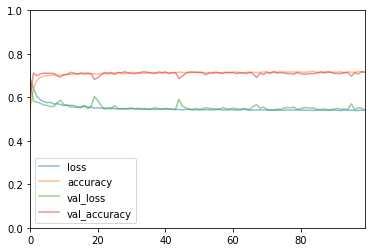

In [203]:
pd.DataFrame(model.history.history).plot(alpha=.5)
plt.gca().set_ylim(0,1)
plt.show()